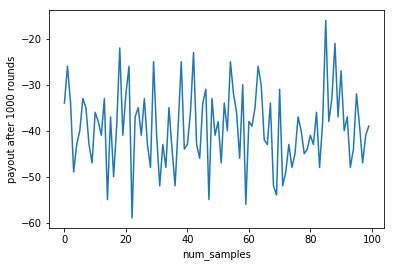

Average payout after 100 rounds is -39.19


In [90]:
import gym
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
env.seed(0)
env.reset()

num_rounds = 100 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

average_payouts = []

for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action 
#         print('ACTION: ' + str(action))
        
        obs, payout, is_done, info = env.step(action)
#         print('OBS: ' + str(obs))
#         print('PAYOUT: ' + str(payout))
#         print('ID_DONE: ' + str(is_done))
#         print('INFO: ' + str(info))

        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

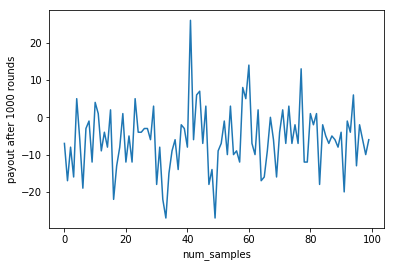

Average payout after 100 rounds is -5.94


In [91]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*10 # 2 to 11
    actions.append([1]*2 + [0]*3 + [1]*5) #12
    actions.extend([[0]*6 + [1]*4]*4) #13-16
    actions.extend([[0]*10]*5) #17-21
    
#     for x in actions:
#         print(x)
    
    # dealer_up_card-2 takes care of input 1 which correcly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

# Make sure actions have been stored correctly mainly when dealer's upcard is A
# assert (normal_strategy(15, 2)) == 0
# assert (normal_strategy(15, 1)) == 1


num_rounds = 100 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples
total_payout = 0 # to store total payout over 'num_rounds'

average_payouts = []

for x in range(num_samples):
    round = 1
    round_payout = 0
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        
        # Take action based on normal strategy stored above
        action = normal_strategy(player_sum, dealer_up_card) 
#         print(player_sum)
#         print(dealer_up_card)
#         print(normal_strategy(player_sum, dealer_up_card))
        
        
        obs, payout, is_done, _ = env.step(action)
        round_payout += payout
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(round_payout)

    
plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))


In [103]:
import random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam

class DQNAgent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, time = 30000):
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = env.observation_space
        self.memory = deque(maxlen=2000) # Record past experiences- [(state, action, reward, next_state, done)...]
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning = True
        self.model = self._build_model()
        
        self.time = time # Change epsilon each episode based on this
        self.time_left = time
        self.small_decrement = (0.1 * epsilon) / (0.3 * self.time_left) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * self.time_left) # reduces epilon faster
        print('HELLO')
    
    # Build Neural Net
    def _build_model(self):
        model = Sequential()
        model.add(Dense(3, input_shape =(3,), activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.alpha))
        
        return model
       
#     # Remember function that stores states, actions, rewards, and done to memory
#     def remember(self, state, action, reward, next_state, done):
#         self.memory.append([state, action, reward, next_state, done])

    def choose_action(self, state):
        """
        Choose which action to take, based on the observation. 
        Uses greedy epsilon for exploration/exploitation.
        """

        # if random number > epsilon, act 'rationally'. otherwise, choose random action
        
        if np.random.rand() <= self.epsilon:
#             print(np.random.rand())
#             print(self.epsilon)
#             print('random')
#             print('-------')
            
            action = random.randrange(self.action_size)

            
        else:
#             print('logic')

            action_value = self.model.predict(state)
#             print(action_value)
#             print('-------')
            action = np.argmax(action_value[0])
        
        self.update_parameters()
        return action
        
    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
        if self.time_left > 0.7 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.5 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.2 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.000
            self.learning = False

#         print(self.time_left)
        #         print(self.time)
        self.time_left -= 1       


    def learn(self, observation):
#         minibatch = random.sample(self.memory, batch_size)
#         print(minibatch)
        state, action, reward, next_state, done = observation
        target = reward
#         print('STATE: ' + str(state))
#             print('next_state: ' + str(state))

#         print('target: ' + str(target))

        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

#         print('target: ' + str(target))


#         print('action: ' + str(action))
#             print(self.model.predict(next_state))
#             print(np.amax(self.model.predict(next_state)[0]))

        target_f = self.model.predict(state)
#             print(target_f)
#         print('target_f: ' + str(target_f))


        target_f[0][action] = target
#         print('target_f: ' + str(target_f))
#             print('target_f: ' + str(target_f))
#         print('-------')

        self.model.fit(state, target_f, epochs=1, verbose=0)
        
        
#             print(self.time)
#         print(self.epsilon)


HELLO
TOTAL PAYOUT: -48.0
Done with sample: 0   --- 4.110227823257446 seconds ---
0.9955333333333338
TOTAL PAYOUT: -27.0
TOTAL PAYOUT: -51.0
TOTAL PAYOUT: -45.0
TOTAL PAYOUT: -39.0
TOTAL PAYOUT: -34.0
TOTAL PAYOUT: -31.0
TOTAL PAYOUT: -50.0
TOTAL PAYOUT: -38.0
TOTAL PAYOUT: -36.0
TOTAL PAYOUT: -46.0
Done with sample: 10   --- 9.755155801773071 seconds ---
0.9493333333333389
TOTAL PAYOUT: -47.0
TOTAL PAYOUT: -49.0
TOTAL PAYOUT: -40.0
TOTAL PAYOUT: -54.0
TOTAL PAYOUT: -57.0
TOTAL PAYOUT: -40.0
TOTAL PAYOUT: -39.0
TOTAL PAYOUT: -21.0
TOTAL PAYOUT: -49.0
TOTAL PAYOUT: -54.0
Done with sample: 20   --- 15.348424911499023 seconds ---
0.9029666666666774
TOTAL PAYOUT: -47.0
TOTAL PAYOUT: -59.0
TOTAL PAYOUT: -54.0
TOTAL PAYOUT: -25.0
TOTAL PAYOUT: -42.0
TOTAL PAYOUT: -27.0
TOTAL PAYOUT: -53.0
TOTAL PAYOUT: -31.0
TOTAL PAYOUT: -41.0
TOTAL PAYOUT: -24.0
Done with sample: 30   --- 21.146556854248047 seconds ---
0.8554333333333493
TOTAL PAYOUT: -50.0
TOTAL PAYOUT: -44.0
TOTAL PAYOUT: -45.0
TOTAL PAY

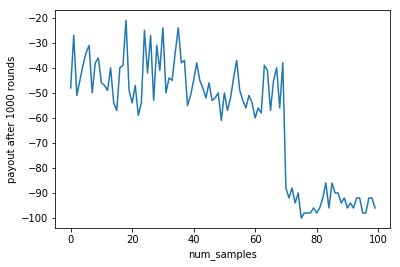

Average payout after 100 rounds is -59.67


In [104]:
import gym
env = gym.make('Blackjack-v0')
env.seed(0)
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt
from collections import deque
import time

start_time = time.time()

# print(agent.model)

num_rounds = 100 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

agent = DQNAgent(env=env, epsilon=1.0, alpha=0.001, gamma=0.1, time=num_rounds*num_samples)

average_payouts = []

state = env.reset()
state = np.reshape(state, [1,3])
# print(type(state))
for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        
#         print(state)
#         print(done)
        action = agent.choose_action(state)
#         print('action: ' + str(action))
        next_state, payout, done, _ = env.step(action)
#         print(next_state)
        next_state = np.reshape(next_state, [1,3])
        
#         print(next_state)
#         print('payout: ' + str(payout))
#         print('-----------')
        
#         agent.remember(state, action, payout, next_state, done)
        total_payout += payout    
        if agent.learning:
            agent.learn([state, action, payout, next_state, done])
        
        state = next_state
        state = np.reshape(state, [1,3])
        
        

        if done:
            state = env.reset() # Environment deals new cards to player and dealer
            state = np.reshape(state, [1,3])
            round += 1
            
        
            
        
        
            
#     if len(agent.memory) > batch_size:
#         print(agent.memory)
        


    average_payouts.append(total_payout)
    print('TOTAL PAYOUT: ' + str(total_payout))

    if sample % 10 == 0:
        print('Done with sample: ' + str(sample) + str("   --- %s seconds ---" % (time.time() - start_time)))
        print(agent.epsilon)
    

# Plot payout per 1000 episodes for each value of 'sample'

plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))